# LS-SPA Demonstration Notebook

### In this notebook, we use the data from the toy example in Section 2.5 of the paper "Efficient Shapley Performance Attribution for Least-Squares Regression" to demonstrate how Shapley values can be computed directly for a linear, least-squares model. We then demonstrate how LS-SPA can be used to generate the same Shapley attribution. In this specific case, we have a very small number of features, so it is feaible to compute the exact Shapley attribution. When the number of features exceeds 15, this is no longer the case. LS-SPA is able to accurately approximate Shapley attributions for linear least-squares models even when the number of features exceeds 1000.

## Imports

In [1]:
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt

from ls_spa import ls_spa

## Data loading

In [2]:
N = 50
M = 50
p = 3

### The rows of $X$ correspond to observations and the columns of $X$ correspond to features. We fit a least-squares model on the training data `X_train` and `y_train` and evaluate its performance on the test data `X_test` and `y_test`.

In [3]:
X = np.load("./data/X_train.npy")
X_tst = np.load("./data/X_test.npy")
y = np.load("./data/y_train.npy")
y_tst = np.load("./data/y_test.npy")

## Direct computation of lifts and $R^2$

### We compute the out-of-sample $R^2$ for a least-squares model fitted on each subset of our features.

In [4]:
R2 = np.zeros((tuple(2 for _ in range(p))))

for n in range(2 ** p):
    mask = [n // (2 ** i) % 2 for i in range(p)]
    indices = list(itertools.compress(range(p), mask))

    X_mod = X[:,indices]
    X_tst_mod = X_tst[:,indices]
    theta = np.linalg.lstsq(X_mod, y, rcond=1e-5)[0]
    R2[*mask] = (np.linalg.norm(y_tst) ** 2 - np.linalg.norm((X_tst_mod @ theta) - y_tst) ** 2) / (np.linalg.norm(y_tst) ** 2)

R2 = np.around(R2, 2)

### For every ordering of our features, we remove one from our model and re-fit sequentially. For each feature, we consider the change in the $R^2$ of the model due to its addition/removal. For a single ordering, the vector of these performance differences due to each feature is a lift vector. The Shapley attribution of our model is the average of the lift vectors for every possible ordering of the features.

In [5]:
attrs = np.zeros(p)
lifts = np.zeros((math.factorial(p), p))
perms =  list(itertools.permutations(range(p)))

for i, perm in enumerate(perms):
    inds = [0,0,0]
    perf = R2[*inds]
    for lift in perm:
        inds[lift] = 1
        lifts[i,lift] =  R2[*inds] - perf
        perf = R2[*inds]

attrs = np.around(np.mean(lifts, axis=0), 2)

### We display the $R^2$ for the model fitted with each subset of the features, and we also display the lift vectors corresponding to each permutation of the features.

In [6]:
print("{: ^8}| {}".format("Subset", "R^2"))
print("----------------")
for n in range(2 ** p):
    mask = [n // (2 ** i) % 2 for i in range(p)]
    indices = list(itertools.compress(range(p), mask))
    S = "{" + "".join(str(idx + 1) + "," for idx in indices)[:-1] + "}"

    print("{: ^8}| {}".format(S, R2[*mask]))

 Subset | R^2
----------------
   {}   | 0.0
  {1}   | 0.81
  {2}   | 0.69
 {1,2}  | 0.92
  {3}   | -0.43
 {1,3}  | 0.82
 {2,3}  | 0.69
{1,2,3} | 0.92


In [7]:
print("{: <12}| {}".format("Permutation", "Lift vector"))
print("-------------------------")
for i, perm in enumerate(perms):
    pi = "(" + "".join(str(p + 1) + "," for p in perm)[:-1] + ")"
    print("{: ^12}| {}".format(pi, lifts[i]))

Permutation | Lift vector
-------------------------
  (1,2,3)   | [0.81 0.11 0.  ]
  (1,3,2)   | [0.81 0.1  0.01]
  (2,1,3)   | [0.23 0.69 0.  ]
  (2,3,1)   | [0.23 0.69 0.  ]
  (3,1,2)   | [ 1.25  0.1  -0.43]
  (3,2,1)   | [ 0.23  1.12 -0.43]


## Comparison of true Shapley attribution and LS-SPA

### We use LS-SPA to estimate (in one line) the Shapley attribution we computed exactly. We show both for comparison.

In [8]:
ls_spa_attrs = np.around(np.array(ls_spa(X, X_tst, y, y_tst).attribution), 2)
print("Explicit Shapley attribution: {}".format(attrs))
print("LS-SPA Shapley attribution:   {}".format(ls_spa_attrs))

2023-10-26 16:31:37.970988: W external/xla/xla/service/gpu/nvptx_compiler.cc:673] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Explicit Shapley attribution: [ 0.59  0.47 -0.14]
LS-SPA Shapley attribution:   [ 0.6   0.47 -0.14]


## Data visualization

In [9]:
plt.rcdefaults()

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 14,
    })

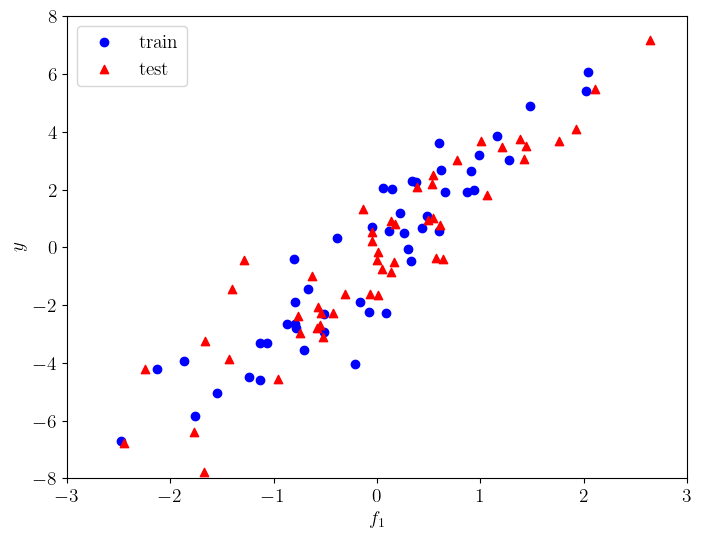

In [10]:
plt.figure(figsize=[8, 6])

plt.scatter(X[:,0], y, color="blue", marker="o", label="train")
plt.scatter(X_tst[:,0], y_tst, color="red", marker="^", label="test")
plt.legend()

plt.xlabel('$f_1$', fontsize=14)
plt.ylabel('$y$', fontsize=14)

plt.xlim(-3,3)
plt.ylim(-8,8)

plt.savefig('./plots/toy_f1.pdf', format='pdf')
plt.show()

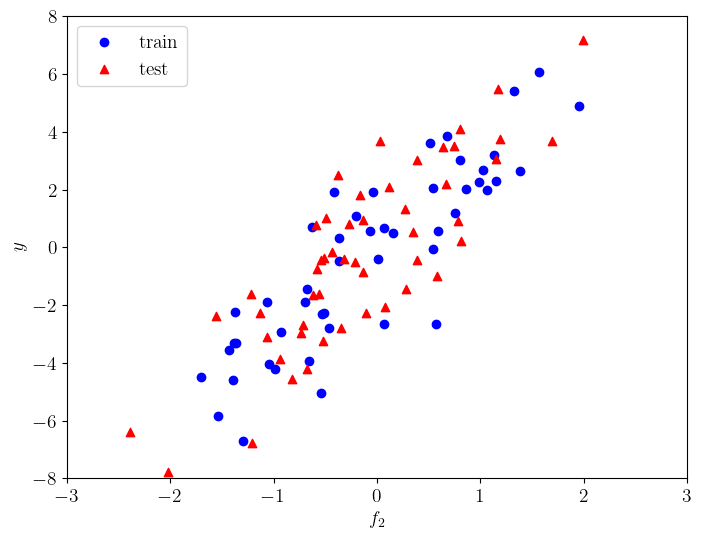

In [11]:
plt.figure(figsize=[8, 6])

plt.scatter(X[:,1], y, color="blue", marker="o", label="train")
plt.scatter(X_tst[:,1], y_tst, color="red", marker="^", label="test")
plt.legend()

plt.xlabel('$f_2$', fontsize=14)
plt.ylabel('$y$', fontsize=14)

plt.xlim(-3,3)
plt.ylim(-8,8)

plt.savefig('./plots/toy_f2.pdf', format='pdf')
plt.show()

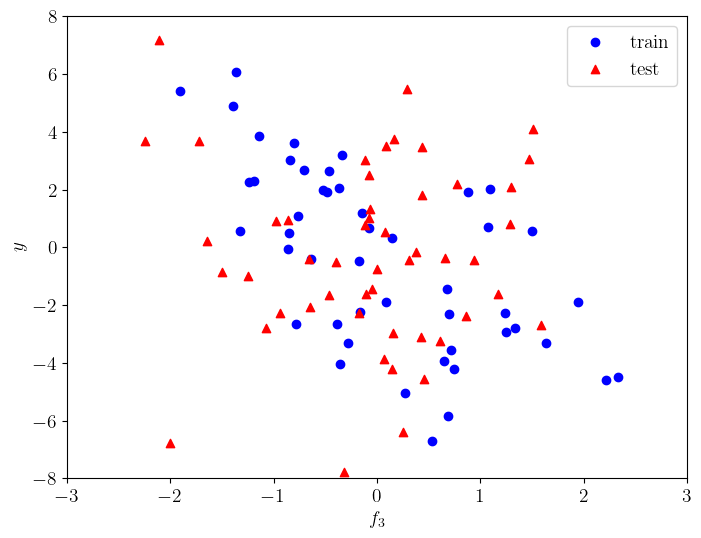

In [12]:
plt.figure(figsize=[8, 6])

plt.scatter(X[:,2], y, color="blue", marker="o", label="train")
plt.scatter(X_tst[:,2], y_tst, color="red", marker="^", label="test")
plt.legend()

plt.xlabel('$f_3$', fontsize=14)
plt.ylabel('$y$', fontsize=14)

plt.xlim(-3,3)
plt.ylim(-8,8)

plt.savefig('./plots/toy_f3.pdf', format='pdf')
plt.show()